# Parameter inference for the simple gene expression

In [1]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np
import pickle 

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

Define the model. The 4 reaction coefficients are the parameters.

In [2]:
r1m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->', 'c1', params = ['c1'])
r2m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->mRNA+protein', 'c2', params = ['c2'])
r3m = TTCME.ChemicalReaction(['mRNA','protein'],'->mRNA', 'c3', params = ['c3'])
r4m = TTCME.ChemicalReaction(['mRNA','protein'],'protein->', 'c4', params = ['c4'])

mdl = TTCME.ReactionSystem(['mRNA','protein'],[r1m, r2m, r3m, r4m], params= ['c1','c2','c3','c4'])

rates = np.array([0.002,0.015,0.1,0.01])
IC = [2,4]
N = [64,64]

Load the measurements and the reference from the file.

In [3]:
with open(r"simplegene_64_500k.pickle", "rb") as input_file:
    dct = pickle.load(input_file) 

No = dct['time_observation'].size
time_observation = dct['time_observation']
reaction_time = dct['reaction_time']
reaction_jumps = dct['reaction_jumps']
reaction_indices = dct['reaction_indices']
observations = dct['observations']
observations_noise = dct['observations_noise']
dT = time_observation[1]-time_observation[0]
sigma = dct['sigma']
sample_posterior_mcmc = dct['sample']

Plot the observations and the true trajectory.

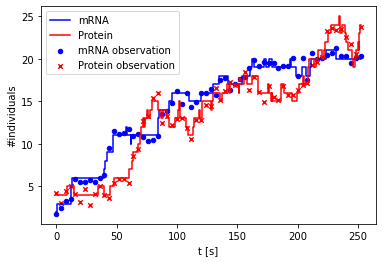

In [4]:
plt.figure()
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,0],2)[:-1],'b')
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,1],2)[:-1],'r') 
plt.scatter(time_observation,observations_noise[:,0],c='b',s=20)
plt.scatter(time_observation,observations_noise[:,1],c='r',marker='x',s=20)
plt.xlabel('t [s]')
plt.ylabel('#individuals')
plt.legend(['mRNA','Protein','mRNA observation','Protein observation'])

Define the basis of the parameter space.

In [5]:
Nl = 64
mult = 6
param_range = [[0,rc*mult] for rc in rates]
basis_param = [TTCME.basis.BSplineBasis(Nl,[p[0],p[1]],deg = 2) for p in param_range]

Define the prior distribution (independent gamma).

In [6]:
mu = rates
var = rates / np.array([1000,350,25,600])
alpha_prior = mu**2/var
beta_prior = mu/var
prior = TTCME.GammaPDF(alpha_prior, beta_prior, basis_param, ['c1','c2','c3','c4'])


Define the initial condition and the joint PDF.

In [7]:
p_ic = TTCME.pdf.SingularPMF(N,IC,['mRNA','protein'])
p0 = p_ic ** prior
p0.normalize()

p = p0.dofs.clone()

print(p0)

Probability density function:
p(mRNA,protein,c1,c2,c3,c4)

Basis:
Dirac-deltas basis defined on {0, ... ,63} and dimension 64
Dirac-deltas basis defined on {0, ... ,63} and dimension 64
B-spline basis defined on [0, 0.012] and dimension 64
B-spline basis defined on [0, 0.09] and dimension 64
B-spline basis defined on [0, 0.6000000000000001] and dimension 64
B-spline basis defined on [0, 0.06] and dimension 64

DoF:
TT with sizes and ranks:
N = [64, 64, 64, 64, 64, 64]
R = [1, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 384 compression 5.587935447692871e-09



Instantiate the observation operator.

In [8]:
obs_operator = TTCME.pdf.GaussianObservation(N, [sigma]*2)

Compute the CME operator for the parameter dependent case.

In [9]:
Stt,Mtt,Mtt_inv = mdl.generator_tt_galerkin(N, basis_param)
Att = Mtt_inv @ Stt

Instantiate the TT time-domain solver. If the `qtt` flag is `True`, the result will be performed in the QTT format.

In [10]:
if qtt:
    A_qtt = Att.to_qtt()
    fwd_int = TTCME.TimeIntegrator.TTInt(A_qtt, epsilon = 1e-5, N_max = 8, dt_max = 1.0,method='cheby')
    Nbs = 4
    p = p.to_qtt()
else:
    fwd_int = TTCME.TimeIntegrator.TTInt(Att, epsilon = 1e-5, N_max = 64, dt_max = 1.0,method='crank–nicolson')
    Nbs = 4

Perform the perameter inference.

In [11]:
posterior_list  =[]
joint_pdf = p0.copy()
for i in range(1,No):
    
    y = observations_noise[i,:]

    
    po = obs_operator.likelihood(y) 
    #po = po / po.sum()
    
    po = po ** tntt.ones([Nl]*4)

    if qtt: po = po.to_qtt()
    
    print('new observation ',i,'/',No,' at time ',time_observation[i],' ',y)
    
    tme = datetime.datetime.now()
    p = fwd_int.solve(p, dT, intervals = Nbs,qtt = qtt,verb = False, rounding=True, device = 'cpu')
    tme = datetime.datetime.now() - tme
    
    
    print('\tmax rank ',max(p.R))
    p_pred = p
    p_post = po * p_pred
    p_post = p_post.round(1e-10)
    print('\tmax rank (after observation) ',max(p_post.R))
    
    if qtt:
        joint_pdf.dofs = tntt.reshape(p_post,joint_pdf.dofs.N)
        Z = joint_pdf.Z
        joint_pdf.normalize()
        p = p_post / Z
    else:
        joint_pdf.dofs = p_post.clone()
        joint_pdf.normalize()
        p = joint_pdf.dofs.clone()

    
    posterior_pdf = joint_pdf.marginal([0,1])
    posterior_pdf.round(1e-10)
    posterior_list.append(posterior_pdf.copy())



    E = posterior_pdf.expected_value()
    
    print('\tExpected value computed posterior ' ,E)
    # print('\tVariance computed posterior       ' ,V)
    print('\tposterior size ',tntt.numel(p)*8 / 1000000,' MB')
    print('\telapsed ',tme)

new observation  1 / 64  at time  4   [2.51919804 3.08774773]
	max rank  70
	max rank (after observation)  70
	Expected value computed posterior  [tensor(0.0020), tensor(0.0147), tensor(0.0957), tensor(0.0105)]
	posterior size  0.604768  MB
	elapsed  0:00:12.664963
new observation  2 / 64  at time  8   [3.31271408 4.51143619]
	max rank  92
	max rank (after observation)  92
	Expected value computed posterior  [tensor(0.0020), tensor(0.0150), tensor(0.1089), tensor(0.0098)]
	posterior size  1.005856  MB
	elapsed  0:00:11.447563
new observation  3 / 64  at time  12   [3.5537123  5.04546854]
	max rank  94
	max rank (after observation)  94
	Expected value computed posterior  [tensor(0.0020), tensor(0.0162), tensor(0.1063), tensor(0.0095)]
	posterior size  1.05608  MB
	elapsed  0:00:11.932728
new observation  4 / 64  at time  16   [5.82494567 4.10897851]
	max rank  100
	max rank (after observation)  100
	Expected value computed posterior  [tensor(0.0019), tensor(0.0149), tensor(0.1467), tens


Exact rates:                       [0.002 0.015 0.1   0.01 ]

Expected value computed posterior  [0.00192451 0.01512357 0.09987109 0.01057592]
Covariance computed posterior      [[ 1.03492355e-06 -1.35054679e-08  1.05618754e-05 -2.58983751e-10]
 [ 0.00000000e+00  8.67972230e-06 -2.68996258e-07  4.93135707e-06]
 [ 0.00000000e+00  0.00000000e+00  5.41827767e-04 -5.19588169e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.62746650e-06]]
Variance computed posterior        [1.03492355e-06 8.67972230e-06 5.41827767e-04 7.62746650e-06]

Expected MCMC posterior            [0.00192225 0.01507772 0.09992543 0.01052629]
Covariance MCMC posterior          [[ 9.97553209e-07 -1.62168896e-08  9.71236423e-06  3.76307965e-09]
 [-1.62168896e-08  8.49858562e-06 -8.38666295e-08  4.84758086e-06]
 [ 9.71236423e-06 -8.38666295e-08  5.23344484e-04  1.09076657e-07]
 [ 3.76307965e-09  4.84758086e-06  1.09076657e-07  7.51825824e-06]]
Variance MCMC posterior            [9.97549884e-07 8.49855730e-06 5.2

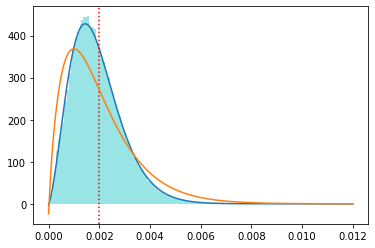

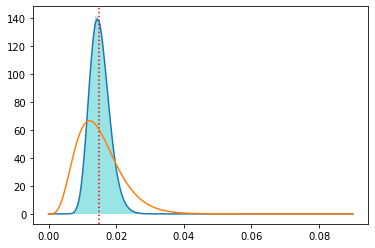

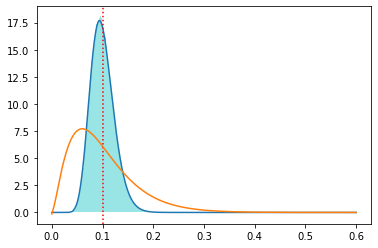

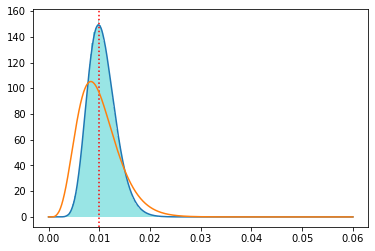

In [12]:
posterior_pdf.normalize()
nburn = 200000

E = posterior_pdf.expected_value()
C = posterior_pdf.covariance_matrix()
V = np.diag(C)

print()
print('Exact rates:                      ',rates)
print('')
print('Expected value computed posterior ' ,np.array(E))
print('Covariance computed posterior     ' ,np.array(C))
print('Variance computed posterior       ' ,V)
# print('Computed modes:                   ',theta_mode)
print('')
print('Expected MCMC posterior           ' ,np.mean(sample_posterior_mcmc[nburn:,:],0))
print('Covariance MCMC posterior         ' ,np.cov(sample_posterior_mcmc[nburn:,:].T))
print('Variance MCMC posterior           ' ,np.std(sample_posterior_mcmc[nburn:,:],0)**2)
print('')
print('Relative absolute error exp       ',np.abs(np.mean(sample_posterior_mcmc[nburn:,:],0)-E)/E * 100,' %')
print('Relative absolute error var       ',np.abs(np.std(sample_posterior_mcmc[nburn:,:],0)**2-V)/V * 100,' %')
print('')
print('Expected value prior              ' ,alpha_prior/beta_prior)
print('Variance computed prior           ' ,alpha_prior/beta_prior/beta_prior)
print('')


post_1 = posterior_pdf.marginal([1,2,3])
post_2 = posterior_pdf.marginal([0,2,3])
post_3 = posterior_pdf.marginal([0,1,3])
post_4 = posterior_pdf.marginal([0,1,2])


for i in range(4):
    pr = prior.marginal([j for j in range(4) if i!=j])
    po = posterior_pdf.marginal([j for j in range(4) if i!=j])
    x = np.linspace(param_range[i][0],param_range[i][1],1000)
    
    
    plt.figure()
    plt.plot(x, po[x].numpy())
    plt.hist(sample_posterior_mcmc[nburn:,i],bins=128,density=True,color='c',alpha=0.4)
    plt.axvline(rates[i],c='r',linestyle=':')
    plt.plot(x, pr[x].numpy())

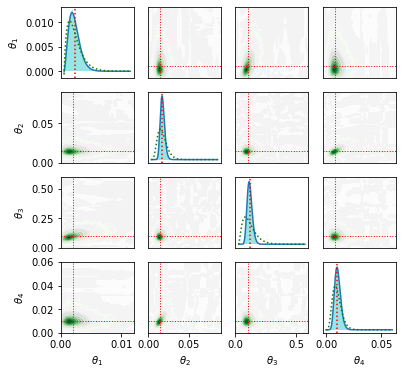

In [13]:
plt.figure(figsize = [6,6])

k = 0
for i in range(4):
    for j in range(4):
        k += 1
        if i==j:
            plt.subplot(4, 4, k)
            
            theta = np.linspace(param_range[i][0],param_range[i][1],1000)
            pr = prior.marginal([k for k in range(4) if i!=k])[theta].numpy()
            po = posterior_pdf.marginal([k for k in range(4) if i!=k])[theta].numpy()
           
            plt.plot(theta,po/np.max(po)*np.max(theta))
            count, bins = np.histogram(sample_posterior_mcmc[nburn:,i],bins=128,density=True)
            count = count/np.max(po)*np.max(theta)
            plt.hist(bins[:-1], bins, weights=count,color='c',alpha=0.4)
            plt.axvline(rates[i],c='r',linestyle=':')
            plt.plot(theta,pr/np.max(po)*np.max(theta),'g:')
            
        else:
            plt.subplot(4, 4, k)
             
            if j<i: 
                theta1 = np.linspace(param_range[j][0],param_range[j][1],127)
                theta2 = np.linspace(param_range[i][0],param_range[i][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T
                

                counts,ybins,xbins,image = plt.hist2d(sample_posterior_mcmc[nburn:,j],sample_posterior_mcmc[nburn:,i],bins=100,density = True, range =[[T1.min(), T1.max()],[T2.min(), T2.max()]])
                plt.contour(counts.T,extent=[T1.min(), T1.max(), T2.min(), T2.max()],linewidths=1,levels=10, cmap =plt.cm.Greens)

                plt.contourf(T1, T2, po, cmap='gray_r', levels =32)

                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
            else: 
                theta1 = np.linspace(param_range[i][0],param_range[i][1],127)
                theta2 = np.linspace(param_range[j][0],param_range[j][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T

                counts,ybins,xbins,image = plt.hist2d(sample_posterior_mcmc[nburn:,j],sample_posterior_mcmc[nburn:,i],bins=100,density = True, range =[[T2.min(), T2.max()],[T1.min(), T1.max()]])
                plt.contour(counts.T,extent=[T2.min(), T2.max(), T1.min(), T1.max()],linewidths=1,levels=10, cmap =plt.cm.Greens)

                plt.contourf(T2, T1, po, cmap='gray_r', levels =32)

                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
        
        if i==3: plt.xlabel(r'$\theta_'+str(j+1)+'$')
        if j==0: plt.ylabel(r'$\theta_'+str(i+1)+'$')
        
        if j>0: plt.yticks([])
        if i<3: plt.xticks([])

plt.savefig('simple_gene_post.pdf')